# Solving CartPole-v0 with the policy gradient algorithm REINFORCE

The following is an implementation of the [REINFORCE]() algorithm described in ([Policy Gradient Methods for
Reinforcement Learning with Function Approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)).

The environment Cartpole-v0 is used to test the algorithm, was created by OpenAi and is described in more detail here cartpolev0 and here doc.

If the algorithm manages to execute the simulation of the cartpole for a 100 episodes, keeping it balanced for more then 195 steps the environment is said to be solved.

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
def print_step(state, reward, done, info):
    print(f"state: {state},\nreward: {reward},\ndone: {done},\ninfo: {info}")

A quick look at the environment:

In [3]:
env = gym.make('CartPole-v0')

In [4]:
initial_state = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print_step(state, reward, done, info)

state: [-0.03463957  0.18047958 -0.00039097 -0.28770428],
reward: 1.0,
done: False,
info: {}


In [5]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

Create the policy network

In [99]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, 
                 input_dim=4, 
                 hidden_dim=[32, 32], 
                 output_dim=2):
        super(PolicyNetwork, self).__init__()
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        
    def forward(self, state):
        
        x = F.relu(self.input_layer(state))
        for hidden in self.hidden_layers:
            x = F.leaky_relu(hidden(x))
        x = F.softmax(self.output_layer(x), dim=-1)
        
        return x
    
model = PolicyNetwork()
learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
initial_state = env.reset()
pred = model(torch.from_numpy(initial_state).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state, reward, done, info = env.step(action)
print("pred: ",pred)
print_step(state, reward, done, info)

pred:  tensor([0.6076, 0.3924], grad_fn=<SoftmaxBackward>)
state: [ 0.02744662 -0.21653217 -0.0163334   0.32637974],
reward: 1.0,
done: False,
info: {}


In [101]:
def discount_rewards(rewards, gamma=.99):
    lenr = len(rewards)
    discounted_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards
    discounted_return /= discounted_return.max()
    return discounted_return.flip(dims=(0,))

In [102]:
def loss_fn(preds, rewards):
    #self.loss = -tf.reduce_mean(tf.log(selected_action_prob) * self.rewards)
    return -1 * torch.mean(rewards * torch.log(preds))


Training the REINFORCE ALGORITHM

In [103]:
MAX_DUR = 200
MAX_EPISODES = 5000
gamma = 0.99

action_space = np.array([0,1])
score = []
actions_taken = {}

scores_window = deque(maxlen=100)

def interact_with_environment():
    #start the environment.
    state = env.reset()
    done = False
    experiences = []
    episode_reward = 0
    #interacting with the environment, continue untill the pole falls (done == True) or max 200 steps. 
    for t in range(MAX_DUR):
        action_prob = model(torch.from_numpy(state).float()).detach()
        
        action = np.random.choice(action_space, p=action_prob.data.numpy())
        
        actions_taken[action] = 1 + actions_taken.get(action, 0)
        
        next_state, reward, done, info = env.step(action)
        
        experiences.append((state, action, reward * (1-done)))
        episode_reward += 1
        state = next_state
        # the pole fell. 
        if done:
            break
    return experiences, episode_reward, done
    
def train_model(experiences):
    # train the model
    
    sum_reward = 0
    discnt_rewards = []
    rewards = [r for (s,a,r) in experiences]
    rewards.reverse()
    for r in rewards:
        sum_reward = r + gamma * sum_reward
        discnt_rewards.append(sum_reward)
    discnt_rewards.reverse()
    reward_batch = torch.Tensor(discnt_rewards)
    
    #reward_batch = torch.Tensor([r for (s,a,r) in experiences]).flip(dims=(0,))
    discounted_reward = torch.Tensor(reward_batch)
    
    state_batch = torch.Tensor([s for (s,a,r) in experiences])
    action_batch = torch.Tensor([a for (s,a,r) in experiences])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = loss_fn(prob_batch, discounted_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    
for episode in tqdm(range(MAX_EPISODES)):

    experiences, rewards, done = interact_with_environment()
    scores_window.append(rewards)
    ep_len = len(experiences)
    score.append(ep_len)
    if done: 
        train_model(experiences)
    
    if episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
                print(actions_taken)
    if np.mean(scores_window) >= 195:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100,
                                                                      np.mean(scores_window)))
        torch.save(model.state_dict(), 'checkpoint.pth')
        break
    
        

Episode 0	Average Score: 13.00
{0: 9, 1: 4}
Episode 100	Average Score: 22.93
{0: 1317, 1: 989}
Episode 200	Average Score: 43.79
{0: 3497, 1: 3188}
Episode 300	Average Score: 36.36
{0: 5457, 1: 4864}
Episode 400	Average Score: 86.78
{0: 10243, 1: 8756}
Episode 500	Average Score: 119.14
{0: 16732, 1: 14181}
Episode 600	Average Score: 166.34
{0: 25290, 1: 22257}
Episode 700	Average Score: 184.92
{0: 34405, 1: 31634}

Environment solved in 625 episodes!	Average Score: 195.31



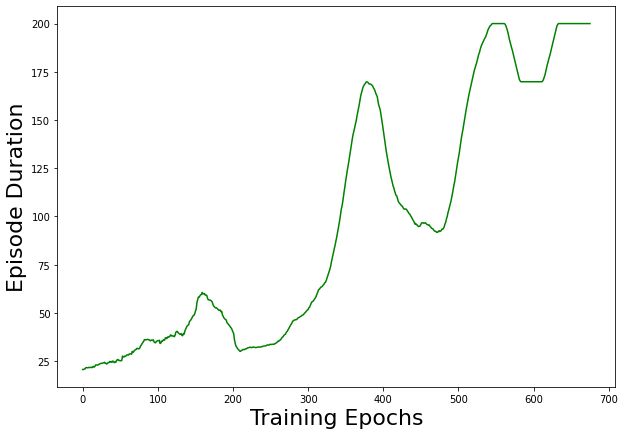

In [104]:
score = np.array(score)
avg_score = running_mean(score, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')
